# Feature Engineering with Open-Source

In this notebook, we will reproduce the Feature Engineering Pipeline from the notebook 2 (02-Machine-Learning-Pipeline-Feature-Engineering), but we will replace, whenever possible, the manually created functions by open-source classes, and hopefully understand the value they bring forward.

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

import preprocessors as pp

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [50]:
df = pd.DataFrame([('bird', 2, 2),
                   ('mammal', 4, np.nan),
                   ('arthropod', 8, 0),
                   ('bird', 2, np.nan)],
                  index=('falcon', 'horse', 'spider', 'ostrich'),
                  columns=('species', 'legs', 'wings'))

In [55]:
df['species','legs','wings'].mode()

KeyError: ('species', 'legs', 'wings')

In [2]:
# load dataset
data = pd.read_csv('../section-04-research-and-development/train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

- mean
- mode
- exponents for the yeo-johnson
- category frequency
- and category to number mappings

from the train set.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [3]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

# Feature Engineering

In the following cells, we will engineer the variables of the House Price Dataset so that we tackle:

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
5. Standardize the values of the variables to the same range

## Target

We apply the logarithm

In [4]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Missing values

### Categorical variables

We will replace missing values with the string "missing" in those variables with a lot of missing data. 

Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values. 

This is common practice.

In [5]:
# let's identify the categorical variables
# we will capture those of type object

cat_vars = [var for var in data.columns if data[var].dtype == 'O']

# MSSubClass is also categorical by definition, despite its numeric values
# (you can find the definitions of the variables in the data_description.txt
# file available on Kaggle, in the same website where you downloaded the data)

# lets add MSSubClass to the list of categorical variables
cat_vars = cat_vars + ['MSSubClass']

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# number of categorical variables
len(cat_vars)

44

In [6]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
BsmtExposure    0.025114
BsmtFinType2    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

In [7]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]

In [8]:
# I print the values here, because it makes it easier for
# later when we need to add this values to a config file for 
# deployment

with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [9]:
with_frequent_category

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [10]:
# replace missing values with new label: "Missing"

# set up the class
cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing)

# fit the class to the train set
cat_imputer_missing.fit(X_train)

# the class learns and stores the parameters
cat_imputer_missing.imputer_dict_

{'Alley': 'Missing',
 'FireplaceQu': 'Missing',
 'PoolQC': 'Missing',
 'Fence': 'Missing',
 'MiscFeature': 'Missing'}

In [11]:
# replace NA by missing

# IMPORTANT: note that we could store this class with joblib
X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

In [12]:
# replace missing values with most frequent category

# set up the class
cat_imputer_frequent = CategoricalImputer(
    imputation_method='frequent', variables=with_frequent_category)

# fit the class to the train set
cat_imputer_frequent.fit(X_train)

# the class learns and stores the parameters
cat_imputer_frequent.imputer_dict_

{'MasVnrType': 'None',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'GarageType': 'Attchd',
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA'}

In [13]:
# replace NA by missing

# IMPORTANT: note that we could store this class with joblib
X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [14]:
# check that we have no missing information in the engineered variables

X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [15]:
# check that test set does not contain null values in the engineered variables

[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing indicator variable
- and then replace the missing values in the original variable with the mean

In [16]:
# now let's identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'SalePrice'
]

# number of numerical variables
len(num_vars)

35

In [17]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

In [18]:
# print, makes my life easier when I want to create the config
vars_with_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [19]:
# add missing indicator

missing_ind = AddMissingIndicator(variables=vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

# check the binary missing indicator variables
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0
55,0,0,0


In [20]:
# then replace missing data with the mean

# set the imputer
mean_imputer = MeanMedianImputer(
    imputation_method='mean', variables=vars_with_na)

# learn and store parameters from train set
mean_imputer.fit(X_train)

# the stored parameters
mean_imputer.imputer_dict_

{'LotFrontage': 69.87974098057354,
 'MasVnrArea': 103.7974006116208,
 'GarageYrBlt': 1978.2959677419356}

In [21]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

# IMPORTANT: note that we could save the imputers with joblib

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [22]:
# check that test set does not contain null values in the engineered variables

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

## Temporal variables

### Capture elapsed time

There is in Feature-engine 2 classes that allow us to perform the 2 transformations below:

- [CombineWithFeatureReference](https://feature-engine.readthedocs.io/en/latest/creation/CombineWithReferenceFeature.html) to capture elapsed time
- [DropFeatures](https://feature-engine.readthedocs.io/en/latest/selection/DropFeatures.html) to drop the unwanted features

We will do the first one manually, so we take the opportunity to create 1 class ourselves for the course. For the second operation, we will use the DropFeatures class.

In [23]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [24]:
vars_with_temp = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
subtract_transformer = pp.SubtractTransformer(target_variable='YrSold', variables=vars_with_temp)
subtract_transformer.fit(X_train)

X_train = subtract_transformer.transform(X_train)
X_test = subtract_transformer.transform(X_test)

X_train[vars_with_temp].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


In [25]:
# now we drop YrSold
drop_features = DropFeatures(features_to_drop=['YrSold'])

X_train = drop_features.fit_transform(X_train)
X_test = drop_features.transform(X_test)

## Numerical variable transformation

### Logarithmic transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the logarightm the positive numerical variables in order to get a more Gaussian-like distribution.

In [26]:
log_transformer = LogTransformer(
    variables=["LotFrontage", "1stFlrSF", "GrLivArea"])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

In [27]:
# check that test set does not contain null values in the engineered variables
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_test[var].isnull().sum() > 0]

[]

In [28]:
# same for train set
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_train[var].isnull().sum() > 0]

[]

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to LotArea.

In [29]:
yeo_transformer = YeoJohnsonTransformer(
    variables=['LotArea'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

/Users/bajajn/learn-deployml/deploying-machine-learning-models/deployml/lib/python3.8/site-packages/scipy/stats/morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/Users/bajajn/learn-deployml/deploying-machine-learning-models/deployml/lib/python3.8/site-packages/scipy/optimize/optimize.py:2555: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/bajajn/learn-deployml/deploying-machine-learning-models/deployml/lib/python3.8/site-packages/scipy/optimize/optimize.py:2148: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/bajajn/learn-deployml/deploying-machine-learning-models/deployml/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


{'LotArea': -12.55283001172003}

In [30]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [31]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Binarize skewed variables

There were a few variables very skewed, we would transform those into binary variables.

We can perform the below transformation with open source. We can use the [Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html) from Scikit-learn, in combination with the [SklearnWrapper](https://feature-engine.readthedocs.io/en/latest/wrappers/Wrapper.html) from Feature-engine to be able to apply the transformation only to a subset of features.

Instead, we are going to do it manually, to give us another opportunity to code the class as an in-house package later in the course.

In [32]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

binarizer = SklearnTransformerWrapper(
    transformer=Binarizer(threshold=0), variables=skewed
)


X_train = binarizer.fit_transform(X_train)
X_test = binarizer.transform(X_test)

X_train[skewed].head()

,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
930,0,0,0,0,0,0
656,0,0,0,0,0,0
45,0,0,0,0,0,0
1348,0,0,0,0,0,0
55,0,0,0,1,0,0


## Categorical variables

### Apply mappings

These are variables which values have an assigned order, related to quality. For more information, check Kaggle website.

In [33]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]
qual_mapper = pp.Mapper(qual_vars, qual_mappings)
qual_mapper.fit(X_train)

X_train=qual_mapper.transform(X_train)
X_test=qual_mapper.transform(X_test)


In [34]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = ['BsmtExposure']

exposure_mapper = pp.Mapper(var,exposure_mappings)
exposure_mapper.fit(X_train)

X_train=exposure_mapper.transform(X_train)
X_test=exposure_mapper.transform(X_test)


In [35]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

finish_mapper = pp.Mapper(finish_vars, finish_mappings)
qual_mapper.fit(X_train)

X_train=finish_mapper.transform(X_train)
X_test=finish_mapper.transform(X_test)

In [36]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = ['GarageFinish']

garage_mapper = pp.Mapper(var, garage_mappings)
garage_mapper.fit(X_train)

X_train=garage_mapper.transform(X_train)
X_test=garage_mapper.transform(X_test)

In [37]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = ['Fence']

fence_mapper = pp.Mapper(var, fence_mappings)
fence_mapper.fit(X_train)

X_train=fence_mapper.transform(X_train)
X_test=fence_mapper.transform(X_test)

In [38]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

To learn more about how to handle categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/?referralCode=A855148E05283015CF06) in Udemy.

In [39]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

30

In [40]:
cat_others

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'PavedDrive',
 'PoolQC',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [41]:
rare_encoder = pp.RareLabelCategoricalEncoder(tol=0.05,variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later :)
rare_encoder.encoder_dict_

{'MSZoning': ['RL', 'RM'],
 'Street': ['Pave'],
 'Alley': ['Missing'],
 'LotShape': ['Reg', 'IR1'],
 'LandContour': ['Lvl'],
 'Utilities': ['AllPub'],
 'LotConfig': ['Inside', 'Corner', 'CulDSac'],
 'LandSlope': ['Gtl'],
 'Neighborhood': ['NAmes',
  'CollgCr',
  'OldTown',
  'Edwards',
  'Somerst',
  'NridgHt',
  'Gilbert',
  'Sawyer'],
 'Condition1': ['Norm', 'Feedr'],
 'Condition2': ['Norm'],
 'BldgType': ['1Fam', 'TwnhsE'],
 'HouseStyle': ['1Story', '2Story', '1.5Fin'],
 'RoofStyle': ['Gable', 'Hip'],
 'RoofMatl': ['CompShg'],
 'Exterior1st': ['VinylSd', 'HdBoard', 'Wd Sdng', 'MetalSd', 'Plywood'],
 'Exterior2nd': ['VinylSd', 'HdBoard', 'Wd Sdng', 'MetalSd', 'Plywood'],
 'MasVnrType': ['None', 'BrkFace', 'Stone'],
 'Foundation': ['PConc', 'CBlock', 'BrkTil'],
 'Heating': ['GasA'],
 'CentralAir': ['Y', 'N'],
 'Electrical': ['SBrkr', 'FuseA'],
 'Functional': ['Typ'],
 'GarageType': ['Attchd', 'Detchd', 'BuiltIn'],
 'PavedDrive': ['Y', 'N'],
 'PoolQC': ['Missing'],
 'MiscFeature': ['Mi

In [42]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 

We will do it so that we capture the monotonic relationship between the label and the target.

To learn more about how to encode categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/?referralCode=A855148E05283015CF06) in Udemy.

In [43]:
# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train, y_train)

# mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'MSZoning': {'RM': 0, 'Rare': 1, 'RL': 2},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Rare': 0, 'Missing': 1},
 'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2},
 'LandContour': {'Lvl': 0, 'Rare': 1},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'LotConfig': {'Inside': 0, 'Corner': 1, 'Rare': 2, 'CulDSac': 3},
 'LandSlope': {'Gtl': 0, 'Rare': 1},
 'Neighborhood': {'Edwards': 0,
  'OldTown': 1,
  'Sawyer': 2,
  'NAmes': 3,
  'Rare': 4,
  'Gilbert': 5,
  'CollgCr': 6,
  'Somerst': 7,
  'NridgHt': 8},
 'Condition1': {'Feedr': 0, 'Rare': 1, 'Norm': 2},
 'Condition2': {'Rare': 0, 'Norm': 1},
 'BldgType': {'Rare': 0, '1Fam': 1, 'TwnhsE': 2},
 'HouseStyle': {'1.5Fin': 0, 'Rare': 1, '1Story': 2, '2Story': 3},
 'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
 'RoofMatl': {'CompShg': 0, 'Rare': 1},
 'Exterior1st': {'Wd Sdng': 0,
  'MetalSd': 1,
  'HdBoard': 2,
  'Rare': 3,
  'Plywood': 4,
  'VinylSd': 5},
 'Exterior2nd': {'Wd Sdng': 0,
  'MetalSd': 1,
  'HdBoard': 2,
  'Rare': 3,
  'Plywood': 4,
  '

In [44]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [45]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [46]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

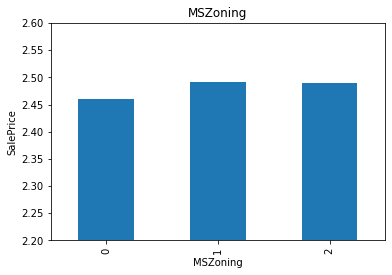

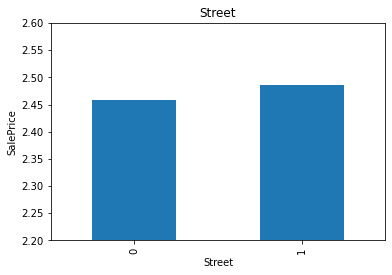

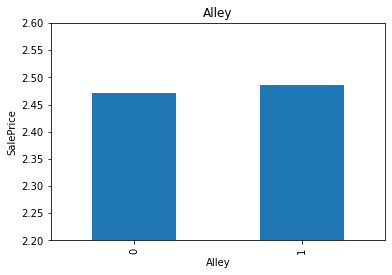

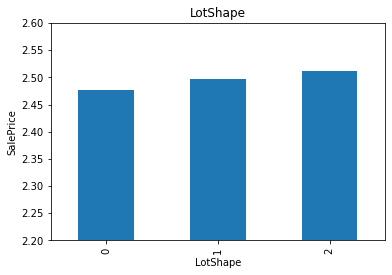

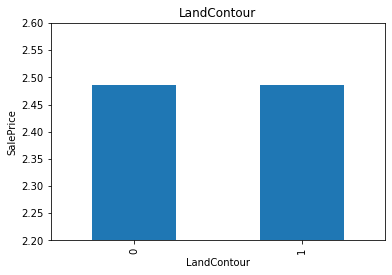

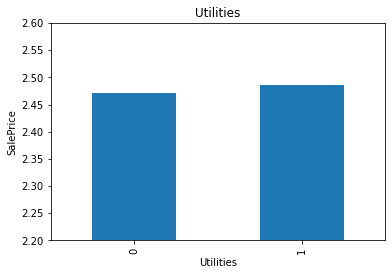

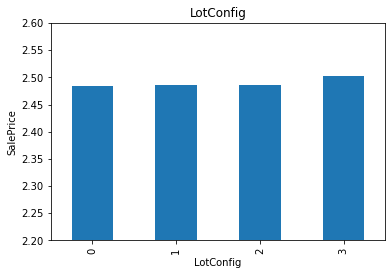

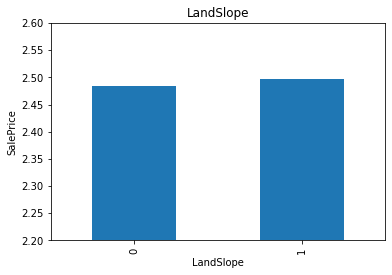

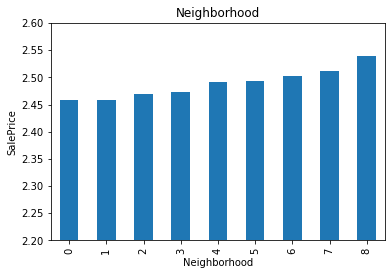

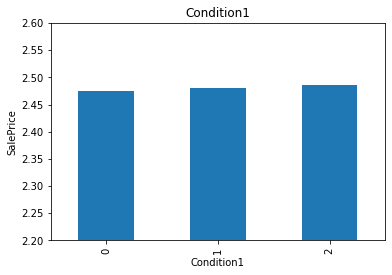

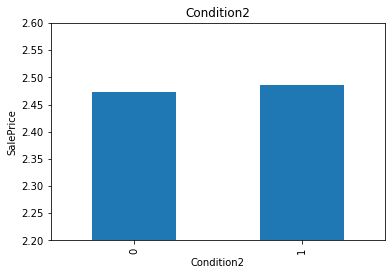

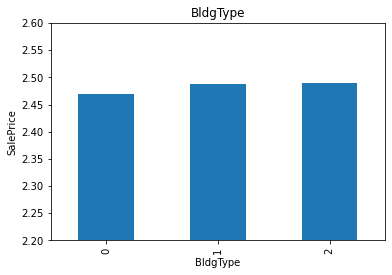

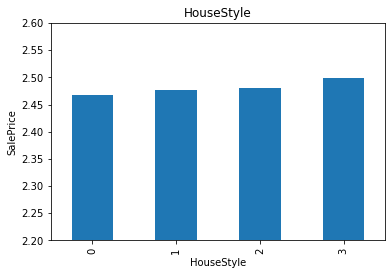

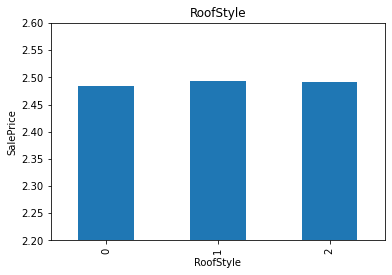

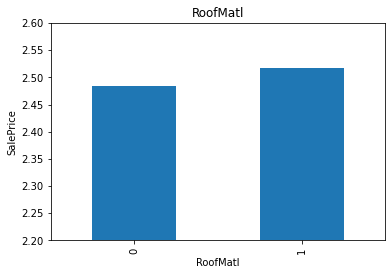

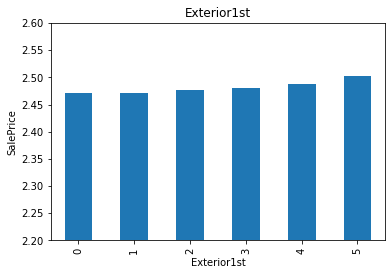

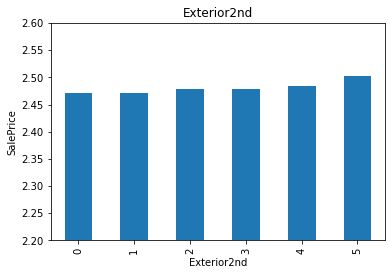

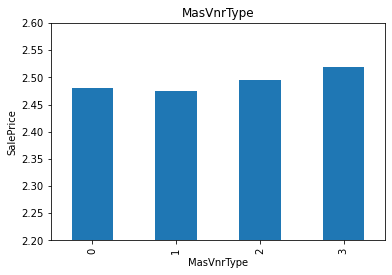

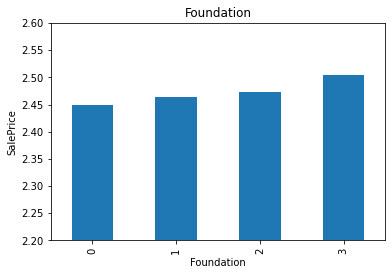

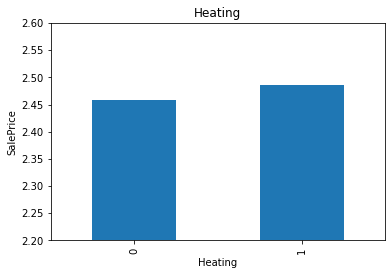

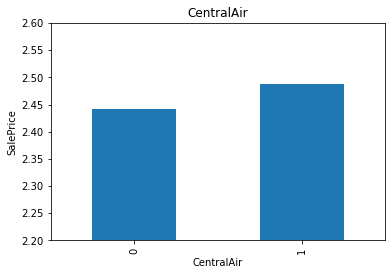

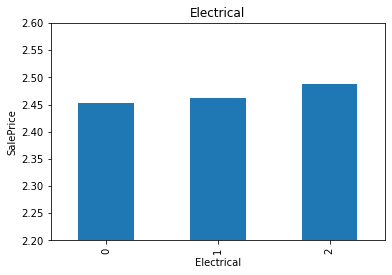

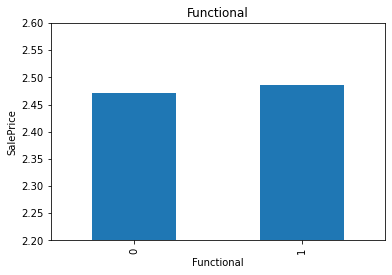

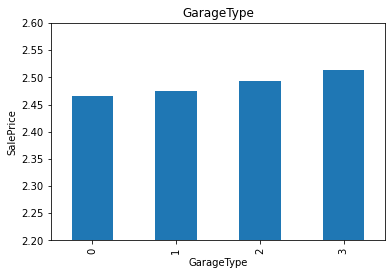

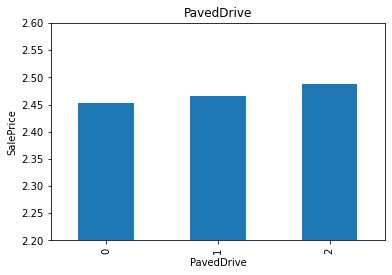

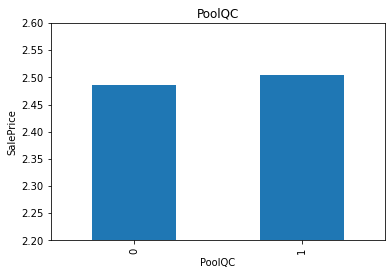

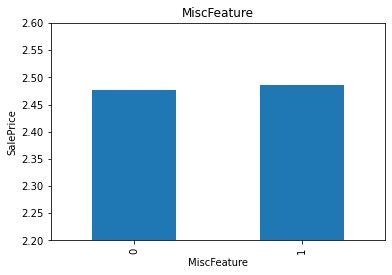

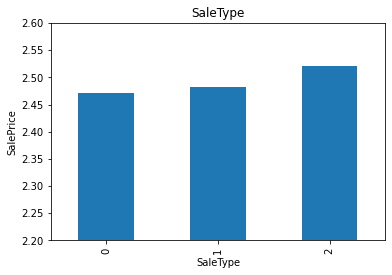

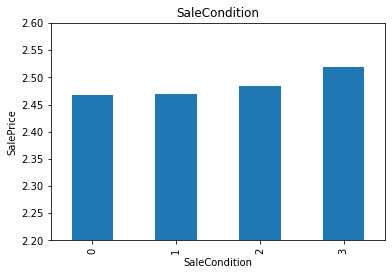

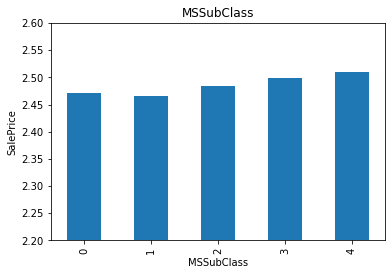

In [47]:
# let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(train, y_train, var):
    
    # function plots median house sale price per encoded
    # category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['SalePrice'].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

The monotonic relationship is particularly clear for the variables MSZoning and Neighborhood. Note how, the higher the integer that now represents the category, the higher the mean house sale price.

(remember that the target is log-transformed, that is why the differences seem so small).

## Feature Scaling

For use in linear models, features need to be either scaled. We will scale features to the minimum and maximum values:

In [48]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [49]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.50,1.0,0.461171,0.0,1.0,1.0,0.5,1.0,1.0,0.0,0.0,0.500,1.0,1.0,0.5,0.666667,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.000000,0.666667,0.666667,0.666667,1.0,0.002835,0.0,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.0,0.666667,0.018692,1.0,0.75,0.430183,0.5,0.5,1.0,0.116686,0.032907,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.5,0.666667,0.0,0.0,0.0
1,0.50,1.0,0.456066,0.0,1.0,1.0,0.5,0.0,1.0,0.0,0.0,0.375,1.0,1.0,0.5,0.666667,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.4,0.4,0.666667,0.03375,0.666667,0.5,0.666667,0.333333,0.666667,0.000000,0.8,0.142807,0.0,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.0,0.666667,0.457944,0.5,0.25,0.220028,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.5,0.666667,0.0,0.0,0.0
2,0.75,1.0,0.394699,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000,1.0,1.0,1.0,0.666667,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.2,0.2,0.666667,0.25750,1.000000,0.5,1.000000,1.000000,0.666667,0.000000,1.0,0.080794,0.0,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.666667,0.046729,0.5,0.50,0.406206,0.5,0.5,1.0,0.228705,0.149909,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.090909,0.5,0.666667,0.0,0.0,0.0
3,0.50,1.0,0.445002,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.500,1.0,1.0,0.5,0.666667,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.000000,0.666667,0.666667,1.000000,1.0,0.255670,0.0,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.666667,0.084112,0.5,0.50,0.362482,0.5,0.5,1.0,0.469078,0.045704,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.636364,0.5,0.666667,1.0,0.0,0.0
4,0.50,1.0,0.577658,0.0,1.0,1.0,0.5,0.0,1.0,0.0,0.0,0.375,1.0,1.0,0.5,0.666667,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.4,0.8,0.666667,0.17000,0.333333,0.5,0.666667,0.333333,0.666667,0.000000,0.6,0.086818,0.0,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.666667,0.411215,0.5,0.50,0.406206,0.5,0.5,1.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.5,0.666667,0.0,0.0,0.0


# Conclusion

We now have several classes with parameters learned from the training dataset, that we can store and retrieve at a later stage, so that when a colleague comes with new data, we are in a better position to score it faster.

Still:

- we would need to save each class
- then we could load each class
- and apply each transformation individually.

Which sounds like a lot of work.

The good news is, we can reduce the amount of work, if we set up all the transformations within a pipeline.

**IMPORTANT**

In order to set up the entire feature transformation within a pipeline, we still need to create a class that can be used within a pipeline to map the categorical variables with the arbitrary mappings, and also, to capture elapsed time between the temporal variables.

We will take that opportunity to create an in-house package.